In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import os
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import time

In [2]:
# 创建保存结果的文件夹
# Create a folder where the results are saved
result_dir = 'results/logistic_regression_results'
os.makedirs(result_dir, exist_ok=True)

In [9]:
# 加载数据
# Load the data
print("加载数据")
start_time = time.time()
file_path = 'data/train.csv'
data = pd.read_csv(file_path)
print(f"数据加载完毕，耗时 {time.time() - start_time:.2f} 秒")

加载数据
数据加载完毕，耗时 4.78 秒


In [10]:
# 处理缺失值，用列的平均值填充
# Missing values are processed, populated with the average of the columns
print("处理缺失值")
data.fillna(data.mean(), inplace=True)

处理缺失值


In [11]:
# 编码离散特征
# Encode discrete features
print("编码离散特征")
label_encoders = {}
for col in tqdm(data.columns, desc="编码离散特征"):
    if 'cat' in col:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

编码离散特征


编码离散特征: 100%|██████████| 60/60 [00:00<00:00, 73.51it/s]


In [12]:
# 标准化数值特征
# Normalize numeric features
print("标准化数值特征")
scaler = StandardScaler()
num_features = [col for col in data.columns if 'num' in col]
data[num_features] = scaler.fit_transform(data[num_features])


标准化数值特征


In [13]:
# 数据拆分为特征和目标变量
# Data is split into features and target variables
print("拆分数据集")
X = data.drop(columns=['id', 'target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

拆分数据集


In [14]:
# 重新数据平衡训练数据
# Rebalance the training data
print("重新平衡训练数据")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

重新平衡训练数据


In [15]:
# 训练逻辑回归模型
# Train a logistic regression model
print("训练逻辑回归模型")
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_lr)

训练逻辑回归模型


In [16]:
# 保存模型
# Save the model
model_file = os.path.join(result_dir, 'lr_model.pkl')
joblib.dump(lr_model, model_file)

['results/logistic_regression_results\\lr_model.pkl']

In [17]:
# 输出AUC得分
# Output AUC score
print(f'逻辑回归模型的 AUC: {auc_lr}')

逻辑回归模型的 AUC: 0.817649559762244


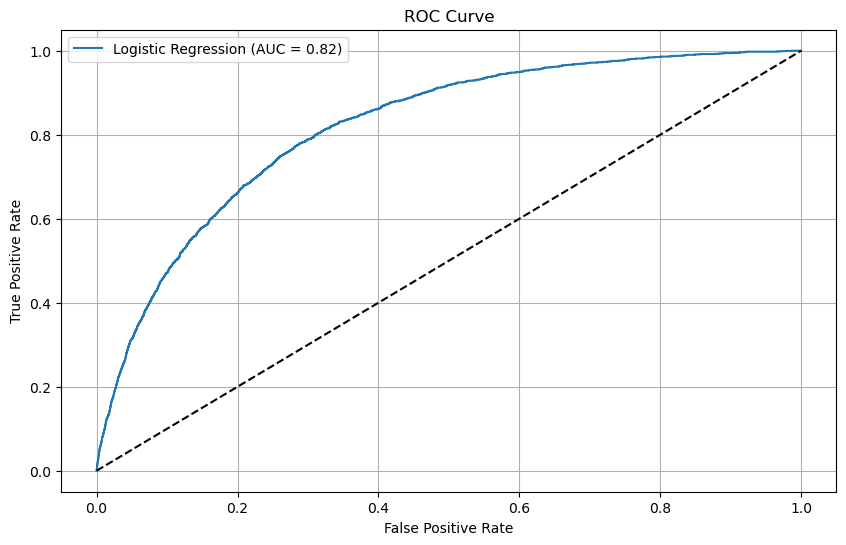

In [18]:
# 生成ROC曲线
# Generate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
roc_curve_file = os.path.join(result_dir, 'roc_curve_lr.png')
plt.savefig(roc_curve_file)
plt.show()

In [19]:
# 计算混淆矩阵
# Calculate the confusion matrix
cm_lr = confusion_matrix(y_test, lr_model.predict(X_test))

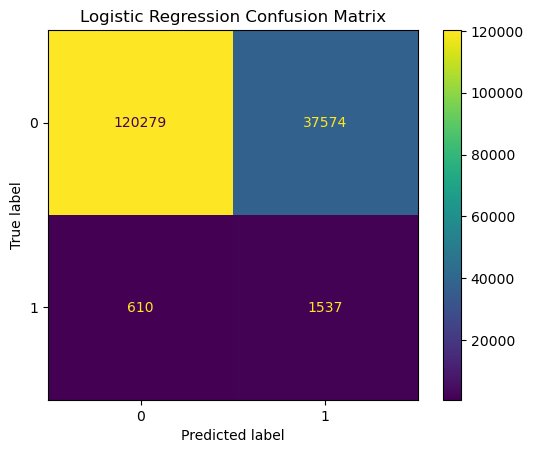

In [20]:
# 显示混淆矩阵
# Show confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.title('Logistic Regression Confusion Matrix')
confusion_matrix_file = os.path.join(result_dir, 'confusion_matrix_lr.png')
plt.savefig(confusion_matrix_file)
plt.show()

In [21]:
# 保存预测结果到CSV文件
# Save the prediction results to a CSV file
test_results_lr = pd.DataFrame({
    'id': data.iloc[X_test.index]['id'],
    'y_pred_lr': y_pred_lr,
    'true_label': y_test
})

test_results_lr.to_csv(os.path.join(result_dir, 'test_predictions_lr.csv'), index=False)
print(f"逻辑回归模型预测结果已保存到 {os.path.join(result_dir, 'test_predictions_lr.csv')}")

逻辑回归模型预测结果已保存到 results/logistic_regression_results\test_predictions_lr.csv
